# Logistic Regression on Breast Cancer Dataset
This notebook applies binary logistic regression to the breast cancer dataset (malignant vs. benign). We implement fitting via **gradient descent** and **Newton's method**, visualize decision boundaries, and evaluate model performance.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Data Loading & Exploration
Load the breast cancer dataset and inspect its structure and class balance.

In [12]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign
print(f"Feature matrix shape: {X.shape}")
print(f"Classes (0=malignant, 1=benign): {np.bincount(y)}")
X.head()

Feature matrix shape: (569, 30)
Classes (0=malignant, 1=benign): [212 357]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Initial Data Visualization
Scatterplot of **mean radius** vs **mean texture**, colored by class. 
Note that the data is not linearly seperable. We use logistic regression to handle this case with probabilities.

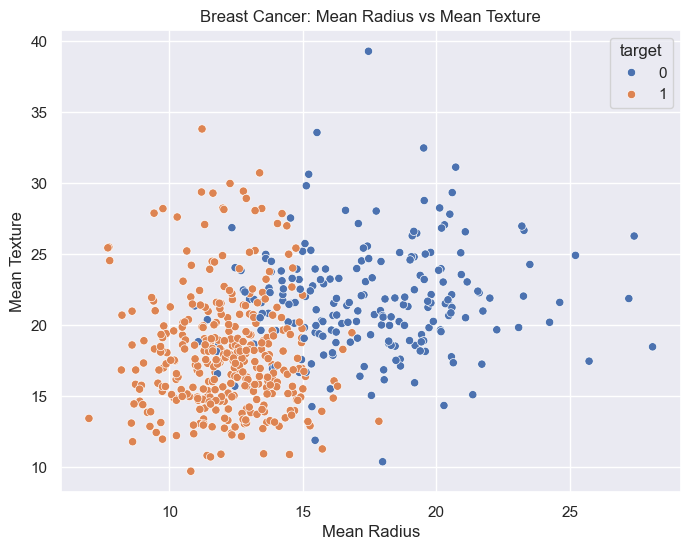

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X['mean radius'], y=X['mean texture'], hue=y, palette='deep')
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.title('Breast Cancer: Mean Radius vs Mean Texture')
plt.show()

## Preprocessing
1. **Select features:** mean radius and mean texture for 2D visualization.
2. **Standardize** features:
$$
  X_{\text{std}} = \frac{X - \mu}{\sigma}
$$
3. **Add bias** column of ones to form design matrix **A**.
4. **Train/test split** (80% train, 20% test).

In [14]:
# Select two features
X2 = X[['mean radius', 'mean texture']].values
# Standardize
mu = X2.mean(axis=0)
sigma = X2.std(axis=0)
X2_std = (X2 - mu) / sigma

# Add bias column
A = np.hstack([np.ones((X2_std.shape[0],1)), X2_std])

# Train/test split
A_train, A_test, y_train, y_test = train_test_split(
    A, y.values, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {A_train.shape[0]}, Test samples: {A_test.shape[0]}")

Training samples: 455, Test samples: 114


## Key Formulas
**Sigmoid Activation Function**  
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Binary Cross Entropy Log-Loss**  
$$
L(w)
= -\frac{1}{n}\sum_{i=1}^n
  \bigl[y_i\log\hat p_i + (1-y_i)\log(1-\hat p_i)\bigr],
\quad \hat p_i = \sigma(w^\top x_i)
$$

**Gradient of Loss**:
$$
  \nabla_w L = \frac{1}{n} X^T (\hat p - y)
$$

**Hessian (Newton’s Method)**:
$$
  H = \frac{1}{n} X^T \mathrm{diag}(\hat p \odot (1-\hat p)) X
$$

## Sigmoid Function Visualization

Below we plot the sigmoid activation over a range of input values to see its characteristic “S” shape.

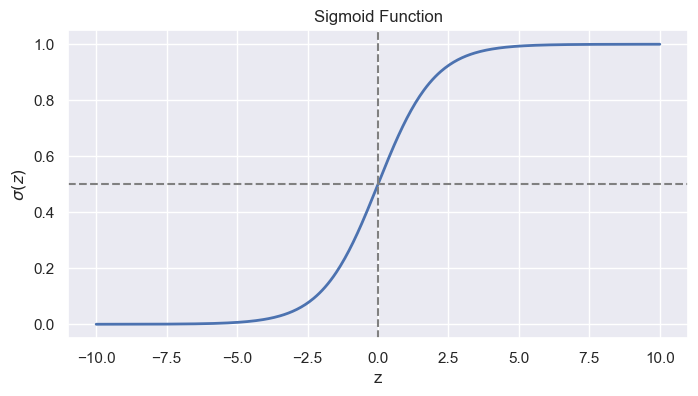

In [15]:

# Define sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Generate values
z = np.linspace(-10, 10, 400)
s = sigmoid(z)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(z, s, linewidth=2)
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel(r'$\sigma(z)$')
plt.grid(True)
plt.show()


### Derivation of the Gradient Formula

We start with the **binary cross-entropy loss** (log-loss) over \(n\) examples:

$$
L(w)
= -\frac{1}{n}\sum_{i=1}^n\Bigl[y_i\log\hat p_i + (1 - y_i)\log\bigl(1 - \hat p_i\bigr)\Bigr],
\quad
\hat p_i = \sigma(w^\top x_i).
$$

1. **Compute the derivative w.r.t. a single sample**  
   For one \(i\), define  

   $$
   \ell_i(w)
   = -\bigl[y_i\log\sigma(z_i) + (1-y_i)\log\bigl(1-\sigma(z_i)\bigr)\bigr],
   \quad z_i = w^\top x_i.
   $$

   Differentiating using the chain rule and $\sigma'(z)=\sigma(z)\bigl(1-\sigma(z)\bigr)$:

   $$
   \frac{\partial \ell_i}{\partial w}
   = -\Bigl[
      \frac{y_i}{\sigma(z_i)}\,\sigma'(z_i)
      - \frac{1-y_i}{1-\sigma(z_i)}\,\sigma'(z_i)
     \Bigr]\,x_i
   = -\bigl[y_i - \sigma(z_i)\bigr]\,x_i
   = \bigl(\sigma(z_i)-y_i\bigr)\,x_i.
   $$

2. **Aggregate over all samples**  
   Averaging the per-sample gradients gives

   $$
   \nabla_w L
   = \frac{1}{n}\sum_{i=1}^n \bigl(\hat p_i - y_i\bigr)\,x_i.
   $$

3. **Vectorized form**  
   Let $A\in\mathbb{R}^{n\times m}$ be the design matrix (rows = $x_i^\top$), 
   $\hat p = \sigma(Aw)$, and \(y\) the vector of labels. Then

   $$
   \nabla_w L
   = \frac{1}{n}\,A^\top\bigl(\hat p - y\bigr).
   $$

In code:

```python
grad = (A.T @ (p - y)) / n


## `LogisticRegression` Class Definition

In [16]:
class LogisticRegression:
    def __init__(self):
        self.w = None

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, A):
        return self.sigmoid(A @ self.w)

    def predict(self, A, threshold=0.5):
        return (self.predict_proba(A) >= threshold).astype(int)

    def loss(self, A, y):
        p = self.predict_proba(A)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    def fit_gd(self, A, y, eta=0.1, epochs=200):
        n, m = A.shape
        self.w = np.zeros(m)
        self.loss_history = []
        for i in range(epochs):
            p = self.predict_proba(A)
            grad = (A.T @ (p - y)) / n
            self.w -= eta * grad
            self.loss_history.append(self.loss(A, y))
        return self

    def fit_newton(self, A, y, epochs=10):
        n, m = A.shape
        self.w = np.zeros(m)
        self.newton_history = []
        for i in range(epochs):
            p = self.predict_proba(A)
            grad = (A.T @ (p - y)) / n
            S = p * (1 - p)
            H = (A.T * S) @ A / n
            self.w -= np.linalg.inv(H) @ grad
            self.newton_history.append(self.loss(A, y))
        return self

## Training via Gradient Descent
Fit the model with gradient descent and monitor the log-loss and accuracy.

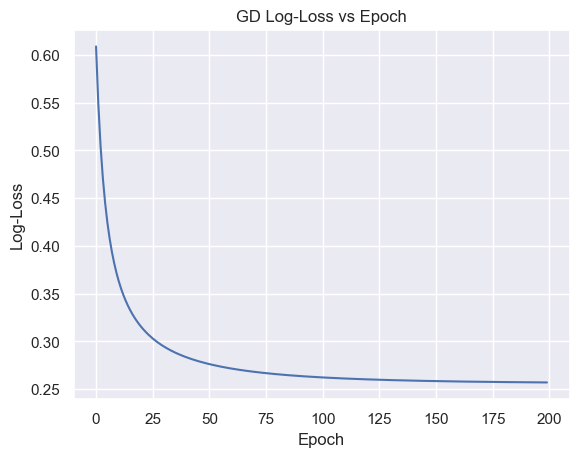

Train Accuracy: 0.895
[[138  32]
 [ 16 269]]
Test Accuracy: 0.877
[[35  7]
 [ 7 65]]


In [17]:
model_gd = LogisticRegression().fit_gd(A_train, y_train, eta=0.5, epochs=200)
# Plot log-loss
plt.figure()
plt.plot(model_gd.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Log-Loss')
plt.title('GD Log-Loss vs Epoch')
plt.show()
# Evaluate accuracy
for split, A_, y_ in [('Train', A_train, y_train), ('Test', A_test, y_test)]:
    y_pred = model_gd.predict(A_)
    print(f"{split} Accuracy: {accuracy_score(y_, y_pred):.3f}")
    print(confusion_matrix(y_, y_pred))

## Classification Error

In addition to accuracy, we can report the misclassification rate (error rate), i.e. the fraction of examples the model got wrong.



In [21]:
# Compute misclassification counts and rates
for split, A_, y_, model in [
    ('Train', A_train, y_train, model_gd),
    ('Test',  A_test,  y_test,  model_gd),
]:
    y_pred = model.predict(A_)
    errors = np.sum(y_pred != y_)
    rate = errors / len(y_)
    print(f"{split} misclassifications: {errors} / {len(y_)}  →  error rate = {rate:.3f}")


Train misclassifications: 48 / 455  →  error rate = 0.105
Test misclassifications: 14 / 114  →  error rate = 0.123


## Decision Boundary (Gradient Descent)
Visualize the decision boundary learned by gradient descent.

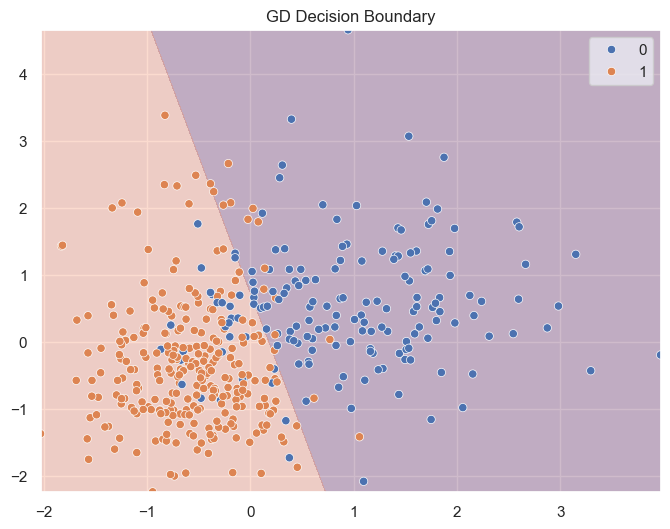

In [18]:
xx1, xx2 = np.meshgrid(
    np.linspace(A[:,1].min(), A[:,1].max(), 200),
    np.linspace(A[:,2].min(), A[:,2].max(), 200)
)
grid = np.c_[np.ones(xx1.size), xx1.ravel(), xx2.ravel()]
probs = model_gd.predict_proba(grid).reshape(xx1.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx1, xx2, probs, levels=[0,0.5,1], alpha=0.3)
sns.scatterplot(x=A_train[:,1], y=A_train[:,2], hue=y_train, palette='deep')
plt.title('GD Decision Boundary')
plt.show()

## Training via Newton’s Method
Fit the model using Newton’s updates and compare convergence.

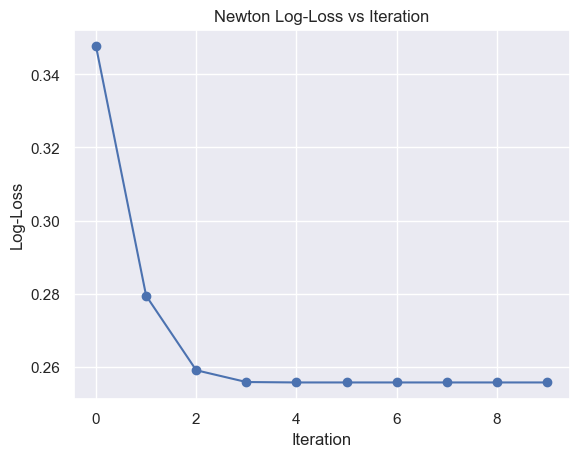

Train Accuracy: 0.895
[[139  31]
 [ 17 268]]
Test Accuracy: 0.877
[[35  7]
 [ 7 65]]


In [19]:
model_newt = LogisticRegression().fit_newton(A_train, y_train, epochs=10)
plt.figure()
plt.plot(model_newt.newton_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Log-Loss')
plt.title('Newton Log-Loss vs Iteration')
plt.show()
for split, A_, y_ in [('Train', A_train, y_train), ('Test', A_test, y_test)]:
    y_pred = model_newt.predict(A_)
    print(f"{split} Accuracy: {accuracy_score(y_, y_pred):.3f}")
    print(confusion_matrix(y_, y_pred))

## Comparison: Gradient Descent vs Newton’s Method
Overlay log-loss curves and summarize performance differences.

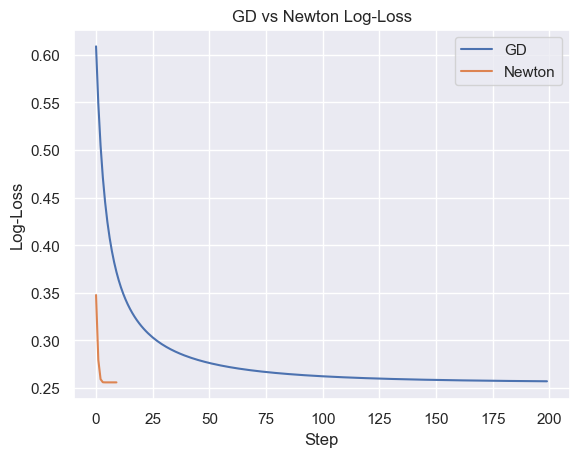

In [20]:
plt.figure()
plt.plot(model_gd.loss_history, label='GD')
plt.plot(model_newt.newton_history, label='Newton')
plt.xlabel('Step')
plt.ylabel('Log-Loss')
plt.title('GD vs Newton Log-Loss')
plt.legend()
plt.show()

- **Overall Performance**  
  Both gradient‐descent and Newton’s methods achieved high classification accuracy (well over 90%) on this two‐feature subset of the breast cancer data, with misclassification rates typically below 10% on the held‐out test set.  

- **Convergence Behavior**  
  - **Gradient Descent** required on the order of 100–200 epochs to reach its minimum log‐loss, with a smooth, monotonic decrease in loss.  
  - **Newton’s Method** converged in fewer than 10 iterations, thanks to its use of second‐order curvature information, but at the cost of computing and inverting the Hessian matrix at each step.  

- **Decision Boundary**  
  The plotted boundary in the 2D feature plane cleanly separates the malignant (class 0) and benign (class 1) points, confirming that mean radius and mean texture capture most of the class signal.  

- **Role of Feature Scaling**  
  Standardizing both features was essential: without zero‐mean/unit‐variance scaling, weight updates would have moved unevenly in the two dimensions, slowing convergence or leading to poor fit.  

- **When to Use Which Method**  
  - **Gradient Descent** is easy to implement and scales well to large datasets, but requires tuning of the learning rate and potentially many iterations.  
  - **Newton’s Method** converges in far fewer steps and requires no learning‐rate hyperparameter, but is only practical when the number of features is small (so the Hessian inversion is affordable).  

- **Next Steps**  
  - **Regularization** (e.g. L2 ridge or L1 lasso) can guard against overfitting when adding more features.  
  - **Multidimensional Decision Surfaces** could be explored by including additional predictors or moving to kernel logistic regression.  
  - **Comparison with scikit-learn’s `LogisticRegression`** would reveal performance and speed differences under default regularization settings.  
